# Brick optimisation unitary multiplication - two sided sweep

Created 22/11/2024

Objectives:
* Sweep over all cases, and perform optimisation to the left and right of the symmetry action.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitons

Will need to update these based off previous work...

In [12]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

In [13]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [14]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [67]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [68]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [69]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [70]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [71]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [28]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [29]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [30]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [31]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [32]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM,
                           normalise=True, svd_cutoff=SVD_CUTOFF):
    U, S, VH = npc.svd(
        t,
        compute_uv=True,
        inner_labels=['vR', 'vL'],
        cutoff=svd_cutoff
    )

    # Truncate tensors:
    U = U[:, :max_inner_dim]
    S = S[:max_inner_dim]
    VH = VH[:max_inner_dim, :]

    if normalise:
        new_norm = np.sqrt(np.sum(S**2))
        S = S/new_norm

    """
    leg = VH.get_leg('vL')

    schmidt_values = npc.diag(S, leg, labels=['vL', 'vR'])
    """

    return U, S, VH

In [134]:
def split_combined_b(b, leftmost_schmidt_values,
                     max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2

    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()
    out_schmidt_values = list()

    current_left_schmidt_values = leftmost_schmidt_values

    for i, ll in enumerate(p_leg_labels[:-1]):
        # In case the bond dimension has been truncated. May need to add in a
        # case if have less schmidt values than the bond dim...
        bond_dim = t.get_leg('vL').get_block_sizes()[0]
        t.iscale_axis(current_left_schmidt_values[:bond_dim], axis='vL')

        tail_legs = p_leg_labels[(i+1):]
        
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=True
        )

        bl = (
            U
            .split_legs()
            .replace_label(ll, 'p')
        )
        bl.iscale_axis(1/current_left_schmidt_values[:bond_dim], axis='vL')
        bl.iscale_axis(S, axis='vR')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        out_schmidt_values.append(S)
        current_left_schmidt_values=S

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs, out_schmidt_values

In [34]:
def split_b(b, max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return b
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [35]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [36]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [37]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [38]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [39]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [40]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [41]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, S, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim
    )

    wl.iscale_axis(S, axis='vR')

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [42]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [313]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        left_schmidt_values,
        block_width,
        block_offset,
        expectations,
        unitaries=list(),
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    group = lambda x: group_elements(x, block_width, block_offset)
    top_grouped_bs = group(top_b_tensors)
    bottom_grouped_bs = group(bottom_b_tensors)
    grouped_schmidt_values = group(left_schmidt_values)

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    new_unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]

    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            new_unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    unitaries.append(new_unitaries)

    for i, u in enumerate(new_unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()
    #new_left_schmidt_values = left_schmidt_values.copy()
    new_left_schmidt_values = list()

    for b, s in zip (top_combined_bs, grouped_schmidt_values):
        """
        print(b)
        print(s)
        print('\n')
        """
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    """
    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b
    """

    return new_top_bs, new_left_schmidt_values

In [44]:
def inner_product_b_tensors(b_tensors, b_bra_tensors=None, left_environment=None,
                            right_environment=None):
    if b_bra_tensors is None:
        b_bra_tensors = b_tensors

    b = b_tensors[0]
    b_bra = b_bra_tensors[0]

    if left_environment is None:
        t = npc.tensordot(b, b_bra.conj(), [['vL',], ['vL*',]])
    else:
        t = npc.tensordot(left_environment, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    for b, b_bra in zip(b_tensors[1:], b_bra_tensors[1:]):
        t = npc.tensordot(t, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    if right_environment is None:
        out = npc.trace(t)
    else:
        out = npc.tensordot(t, right_environment, [['vR', 'vR*'], ['vL', 'vL*']])

    return out

In [45]:
def get_left_side_right_symmetry_environment(
    right_top_b_tensors, right_bottom_b_tensors, symmetry_transfer_matrix
    ):

    if right_bottom_b_tensors is None:
        right_bottom_b_tensors = right_top_b_tensors

    t = get_right_identity_environment_from_tp_tensor(right_top_b_tensors[-1])

    for tb, bb in zip(right_top_b_tensors[::-1], right_bottom_b_tensors[::-1]):
        t = npc.tensordot(t, tb, [['vL',], ['vR']])
        t = npc.tensordot(t, bb.conj(), [['vL*', 'p'], ['vR*', 'p*']])

    t = npc.tensordot(
        t,
        symmetry_transfer_matrix,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    return t

In [46]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [47]:
def two_sided_optimise_layer(
        symmetry_transfer_matrix,
        top_left_b_tensors,
        top_right_b_tensors,
        right_side_left_schmidt_values,
        left_side_right_schmidt_values,
        block_width,
        block_offset,
        right_expectations,
        left_expectations,
        bottom_left_b_tensors=None,
        bottom_right_b_tensors=None,
        left_unitaries=list(),
        right_unitaries=list(),
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_left_b_tensors is None:
        bottom_left_b_tensors = top_left_b_tensors

    if bottom_right_b_tensors is None:
        bottom_right_b_tensors = top_right_b_tensors

    right_side_left_symmetry_environment = (
        get_left_side_right_symmetry_environment(
            top_left_b_tensors,
            bottom_left_b_tensors,
            swap_left_right_indices(symmetry_transfer_matrix)
        )
    )

    right_side_left_symmetry_environment = swap_left_right_indices(
        right_side_left_symmetry_environment
    )
    
    new_right_pair = optimise_layer(
        right_side_left_symmetry_environment,
        top_right_b_tensors,
        right_side_left_schmidt_values,
        block_width,
        block_offset,
        right_expectations,
        right_unitaries,
        bottom_right_b_tensors,
        num_iterations,
        max_virtual_bond_dim
    )

    new_top_right_b_tensors = new_right_pair[0]
    new_right_side_left_schmidt_values = new_right_pair[1]

    left_side_right_symmetry_environment = (
        get_left_side_right_symmetry_environment(
            new_top_right_b_tensors,
            bottom_right_b_tensors,
            symmetry_transfer_matrix
        )
    )

    left_side_right_symmetry_environment = swap_left_right_indices(
        left_side_right_symmetry_environment
    )

    new_left_pair = optimise_layer(
        left_side_right_symmetry_environment,
        top_left_b_tensors,
        left_side_right_schmidt_values,
        block_width,
        block_offset,
        left_expectations,
        left_unitaries,
        bottom_left_b_tensors,
        num_iterations,
        max_virtual_bond_dim
    )

    new_top_left_b_tensors = new_left_pair[0]
    new_left_side_right_schmidt_values = new_left_pair[1]

    return (new_left_pair, new_right_pair)

In [48]:
list(enumerate('hello'))

[(0, 'h'), (1, 'e'), (2, 'l'), (3, 'l'), (4, 'o')]

In [49]:
def initialize_brick_optimisation(symmetry_case, num_sites):
    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    right_site_indices = list(range(
        symmetry_case.right_symmetry_index + 1,
        symmetry_case.right_symmetry_index + 1 + num_sites
    ))

    right_mps_tensors = [
        symmetry_case.psi.get_B(i)
        for k, i in enumerate(right_site_indices)
    ]

    right_side_left_schmidt_values = [
        symmetry_case.psi.get_SL(i)
        for i in right_site_indices
    ]

    left_site_indices = list(range(
        symmetry_case.left_symmetry_index - 1,
        symmetry_case.left_symmetry_index - 1 - num_sites,
        -1
    ))

    left_mps_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for k, i in enumerate(left_site_indices)
    ]
    
    left_mps_tensors = [swap_left_right_indices(b) for b in left_mps_tensors]

    left_side_right_schmidt_values = [
        symmetry_case.psi.get_SR(i)
        for i in left_site_indices
    ]

    right_expectations=list()
    left_expectations=list()
    left_unitaries=list()
    right_unitaries=list()

    return (
        symmetry_transfer_matrix,
        left_mps_tensors,
        right_mps_tensors,
        right_side_left_schmidt_values,
        left_side_right_schmidt_values,
        right_expectations,
        left_expectations,
        left_unitaries,
        right_unitaries
    )

# Test

In [95]:
(
    symmetry_transfer_matrix,
    left_mps_tensors,
    right_mps_tensors,
    right_side_left_schmidt_values,
    left_side_right_schmidt_values,
    right_expectations,
    left_expectations,
    left_unitaries,
    right_unitaries
) = initialize_brick_optimisation(cases[0][1], 8)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [96]:
block_width = 3
num_iterations = 3
num_layers = 10

top_right_mpo_tensors = [right_mps_tensors,]
top_left_mpo_tensors = [left_mps_tensors,]

right_side_left_schmidt_values_list = [right_side_left_schmidt_values,]
left_side_right_schmidt_values_list = [left_side_right_schmidt_values,]

In [97]:
for i in range(num_layers):
    print(f"Layer: {i}")
    
    block_offset = (block_width//2)*i % block_width

    out_quad = two_sided_optimise_layer(
        symmetry_transfer_matrix,
        top_left_mpo_tensors[-1],
        top_right_mpo_tensors[-1],
        right_side_left_schmidt_values_list[-1],
        left_side_right_schmidt_values_list[-1],
        block_width,
        block_offset,
        right_expectations,
        left_expectations,
        right_mps_tensors,
        left_mps_tensors,
        left_unitaries,
        right_unitaries,
        num_iterations
    )

    left_pair, right_pair = out_quad

    top_right_mpo_tensors.append(right_pair[0])
    right_side_left_schmidt_values_list.append(right_pair[1])
    
    top_left_mpo_tensors.append(left_pair[0])
    left_side_right_schmidt_values_list.append(left_pair[1])

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9


In [100]:
left_expectations

[[[0.14819930085588165, 0.14819930085588168, 0.9999976624520969],
  [0.9999976624520971, 0.9999976624520966, 0.9999976624520965],
  [0.9999976624520968, 0.9999976624520963, 0.9999976624520965]],
 [[0.9999976624520954,
   0.9999976624520955,
   0.9999976624520954,
   0.9999976624520954],
  [0.9999976624520952,
   0.9999976624520958,
   0.999997662452096,
   0.9999976624520959],
  [0.9999976624520953,
   0.999997662452096,
   0.9999976624520959,
   0.9999976624520963]],
 [[0.9999999999999984, 0.9999999999999984, 0.999999999999998],
  [0.9999999999999983, 0.9999999999999988, 0.9999999999999988],
  [0.9999999999999992, 0.9999999999999988, 0.9999999999999983]],
 [[0.9999999999999986, 0.9999999999999988, 0.9999999999999987],
  [0.9999999999999986, 0.9999999999999992, 0.9999999999999996],
  [0.9999999999999992, 0.999999999999999, 0.9999999999999987]],
 [[0.9999999999999974,
   0.9999999999999978,
   0.9999999999999977,
   0.9999999999999979],
  [0.9999999999999976,
   0.9999999999999982,
   0

## Test 2

In [219]:
(
    symmetry_transfer_matrix,
    left_mps_tensors,
    right_mps_tensors,
    right_side_left_schmidt_values,
    left_side_right_schmidt_values,
    right_expectations,
    left_expectations,
    left_unitaries,
    right_unitaries
) = initialize_brick_optimisation(cases[6][3], 8)

In [220]:
block_width = 3
num_iterations = 3
num_layers = 10

top_right_mpo_tensors = [right_mps_tensors,]
top_left_mpo_tensors = [left_mps_tensors,]

right_side_left_schmidt_values_list = [right_side_left_schmidt_values,]
left_side_right_schmidt_values_list = [left_side_right_schmidt_values,]

In [221]:
for i in range(num_layers):
    print(f"Layer: {i}")
    
    block_offset = (block_width//2)*i % block_width

    out_quad = two_sided_optimise_layer(
        symmetry_transfer_matrix,
        top_left_mpo_tensors[-1],
        top_right_mpo_tensors[-1],
        right_side_left_schmidt_values_list[-1],
        left_side_right_schmidt_values_list[-1],
        block_width,
        block_offset,
        right_expectations,
        left_expectations,
        right_mps_tensors,
        left_mps_tensors,
        left_unitaries,
        right_unitaries,
        num_iterations
    )

    left_pair, right_pair = out_quad

    top_right_mpo_tensors.append(right_pair[0])
    right_side_left_schmidt_values_list.append(right_pair[1])
    
    top_left_mpo_tensors.append(left_pair[0])
    left_side_right_schmidt_values_list.append(left_pair[1])

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9


In [222]:
len(right_expectations)

10

In [223]:
right_expectations[0]

[[2.3903901858532225e-06, 2.3877735104087863e-05, 0.00023510575263770833],
 [0.00023906970948778554, 0.0002412602440230896, 0.00024126028903127106],
 [0.00024126030545181982, 0.0002412603568844747, 0.0002412603843209281]]

In [224]:
left_expectations[0]

[[0.00866860107833744, 0.08659111865905829, 0.8525963637322157],
 [0.8669714063421184, 0.8749152433545279, 0.8749154065740329],
 [0.8749154661221479, 0.874915652639587, 0.8749157521362574]]

In [225]:
right_expectations[1]

[[0.8749242065026843,
  0.9133442130181771,
  0.9139510709838334,
  0.913951070984664],
 [0.9139510710564096,
  0.9139511514447932,
  0.9139512079323521,
  0.9139512079323516],
 [0.9139512079324541,
  0.9139512555567072,
  0.913951295708545,
  0.9139512957085452]]

In [226]:
right_expectations[-2]

[[0.9816727717739476, 0.9818287979985624, 0.9818415161417119],
 [0.981841616368804, 0.9818416888579358, 0.9818416889000532],
 [0.9818417407091542, 0.9818417781660028, 0.9818417782382712]]

In [227]:
left_expectations[-2]

[[0.9819163416001232, 0.9820724056150812, 0.9820851267054393],
 [0.9820852277486781, 0.9820853008101954, 0.9820853008459857],
 [0.9820853530957941, 0.9820853908741872, 0.9820853909545976]]

In [228]:
right_expectations[-1]

[[0.9822652022793952, 0.9823462988627119, 0.9823463130392746],
 [0.9823465063423088, 0.9823466694104217, 0.9823466827973035],
 [0.9823468037023886, 0.9823469096639988, 0.9823469212829491]]

In [229]:
left_expectations[-1]

[[0.9824960457748416, 0.9825771602971503, 0.9825771743695539],
 [0.9825773672380893, 0.9825775298769691, 0.9825775431809235],
 [0.9825776638021765, 0.9825777694722726, 0.9825777810285257]]

In [230]:
exps = interleave_left_right_expectations(
    left_expectations,
    right_expectations
)

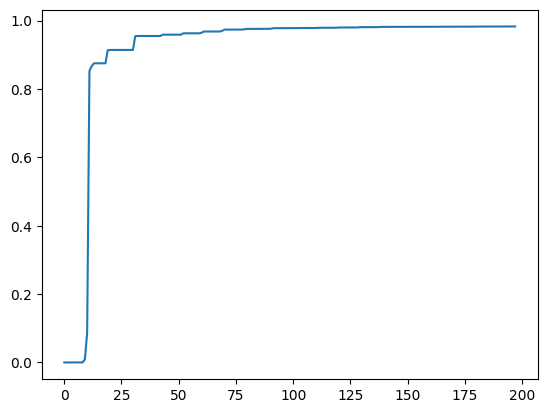

In [231]:
plt.plot(exps)

Looks good!

## Test 3

In [232]:
block_width = 4
num_iterations = 3
num_layers = 10
num_sites = 16

In [233]:
(
    symmetry_transfer_matrix,
    left_mps_tensors,
    right_mps_tensors,
    right_side_left_schmidt_values,
    left_side_right_schmidt_values,
    right_expectations,
    left_expectations,
    left_unitaries,
    right_unitaries
) = initialize_brick_optimisation(cases[0][1], num_sites)

In [234]:
top_right_mpo_tensors = [right_mps_tensors,]
top_left_mpo_tensors = [left_mps_tensors,]

right_side_left_schmidt_values_list = [right_side_left_schmidt_values,]
left_side_right_schmidt_values_list = [left_side_right_schmidt_values,]

In [235]:
for i in range(num_layers):
    print(f"Layer: {i}")
    
    block_offset = (block_width//2)*i % block_width

    out_quad = two_sided_optimise_layer(
        symmetry_transfer_matrix,
        top_left_mpo_tensors[-1],
        top_right_mpo_tensors[-1],
        right_side_left_schmidt_values_list[-1],
        left_side_right_schmidt_values_list[-1],
        block_width,
        block_offset,
        right_expectations,
        left_expectations,
        right_mps_tensors,
        left_mps_tensors,
        left_unitaries,
        right_unitaries,
        num_iterations
    )

    left_pair, right_pair = out_quad

    top_right_mpo_tensors.append(right_pair[0])
    right_side_left_schmidt_values_list.append(right_pair[1])
    
    top_left_mpo_tensors.append(left_pair[0])
    left_side_right_schmidt_values_list.append(left_pair[1])

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9


In [236]:
exps = interleave_left_right_expectations(left_expectations, right_expectations)

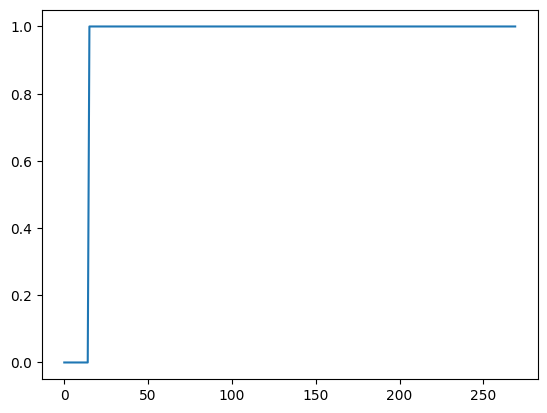

In [237]:
plt.plot(exps)

Looks good!

# Sweep

In [314]:
block_width = 4
num_iterations = 3
num_layers = 10
num_sites = 16

In [315]:
left_mps_tensors = list()
right_mps_tensors = list()
right_side_left_schmidt_values = list()
left_side_right_schmidt_values = list()
right_expectations = list()
left_expectations = list()
left_unitaries = list()
right_unitaries = list()

for j, l in enumerate(cases):
    print(f'Case {j}')

    left_mps_tensors.append(list())
    right_mps_tensors.append(list())
    right_side_left_schmidt_values.append(list())
    left_side_right_schmidt_values.append(list())
    right_expectations.append(list())
    left_expectations.append(list())
    left_unitaries.append(list())
    right_unitaries.append(list())
    
    for c in l[1:]:

        (
            symmetry_transfer_matrix,
            current_left_mps_tensors,
            current_right_mps_tensors,
            current_right_side_left_schmidt_values,
            current_left_side_right_schmidt_values,
            current_right_expectations,
            current_left_expectations,
            current_left_unitaries,
            current_right_unitaries
        ) = initialize_brick_optimisation(c, num_sites)

        top_right_mps_tensors = [current_right_mps_tensors,]
        top_left_mps_tensors = [current_left_mps_tensors,]
        
        right_side_left_schmidt_values_list = [current_right_side_left_schmidt_values,]
        left_side_right_schmidt_values_list = [current_left_side_right_schmidt_values,]

        for i in range(num_layers):
            block_offset = (block_width//2)*i % block_width
        
            out_quad = two_sided_optimise_layer(
                symmetry_transfer_matrix,
                top_left_mps_tensors[-1],
                top_right_mps_tensors[-1],
                right_side_left_schmidt_values_list[-1],
                left_side_right_schmidt_values_list[-1],
                block_width,
                block_offset,
                current_right_expectations,
                current_left_expectations,
                current_left_mps_tensors,
                current_right_mps_tensors,
                current_left_unitaries,
                current_right_unitaries,
                num_iterations
            )
        
            left_pair, right_pair = out_quad
        
            top_right_mps_tensors.append(right_pair[0])
            right_side_left_schmidt_values_list.append(right_pair[1])
            
            top_left_mps_tensors.append(left_pair[0])
            left_side_right_schmidt_values_list.append(left_pair[1])


        left_mps_tensors[-1].append(top_left_mps_tensors[-1])
        right_mps_tensors[-1].append(top_right_mps_tensors[-1])
        right_side_left_schmidt_values[-1].append(right_side_left_schmidt_values_list[-1])
        left_side_right_schmidt_values[-1].append(left_side_right_schmidt_values_list[-1])
        right_expectations[-1].append(current_right_expectations)
        left_expectations[-1].append(current_left_expectations)
        left_unitaries[-1].append(current_left_unitaries)
        right_unitaries[-1].append(current_right_unitaries)

Case 0
Case 1
Case 2
Case 3
Case 4
Case 5
Case 6
Case 7
Case 8
Case 9
Case 10
Case 11
Case 12
Case 13
Case 14
Case 15
Case 16
Case 17
Case 18
Case 19
Case 20


## Overlaps check

In [240]:
len(right_expectations)

21

In [241]:
def interleave_left_right_expectations(left_list, right_list):
    out = list()
    for rl, ll in zip(right_list, left_list):
        out.extend([e for l in rl for e in l])
        out.extend([e for l in ll for e in l])

    return out

In [242]:
full_expectations = list()

for ll, rl in zip(left_expectations, right_expectations):
    full_expectations.append(list())

    for ll1, rl1 in zip(ll, rl):

        data = interleave_left_right_expectations(ll1, rl1)
        full_expectations[-1].append(data)

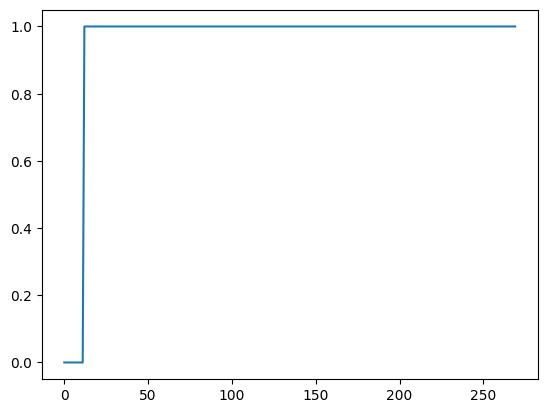

In [243]:
plt.plot(full_expectations[0][0])

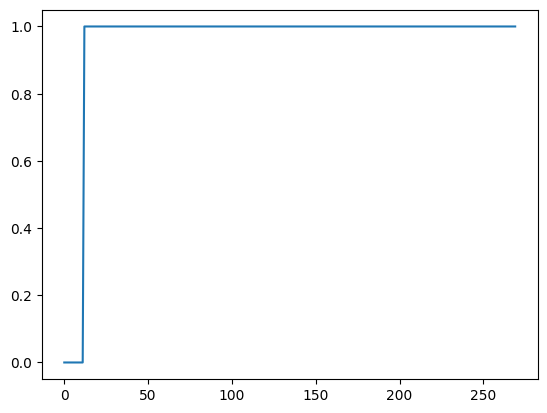

In [244]:
plt.plot(full_expectations[0][1])

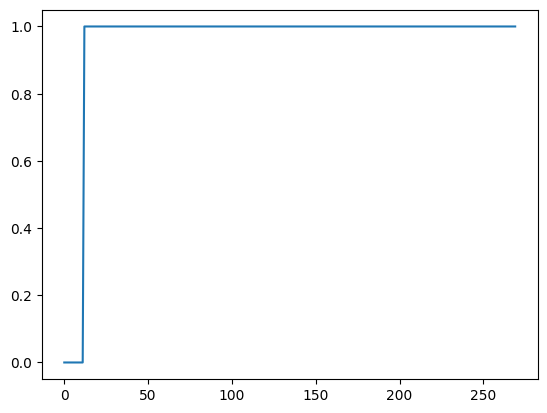

In [245]:
plt.plot(full_expectations[0][2])

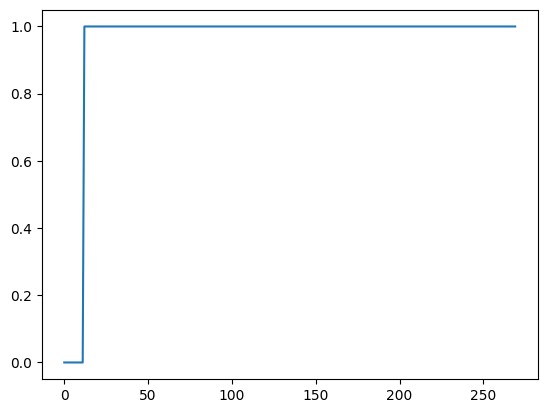

In [246]:
plt.plot(full_expectations[1][0])

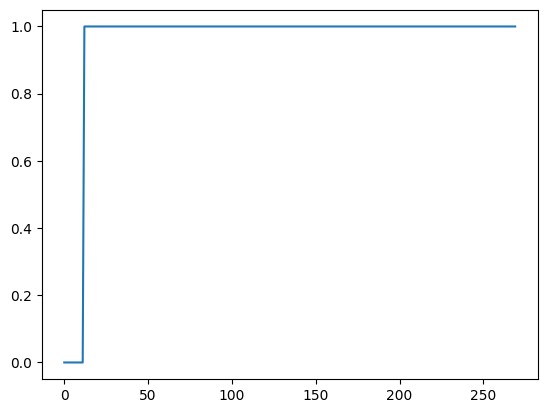

In [247]:
plt.plot(full_expectations[1][1])

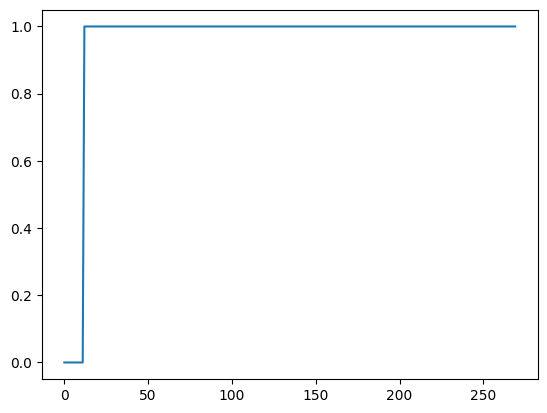

In [248]:
plt.plot(full_expectations[1][2])

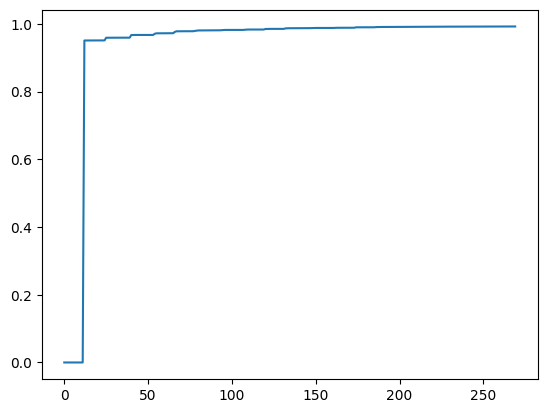

In [249]:
plt.plot(full_expectations[6][2])

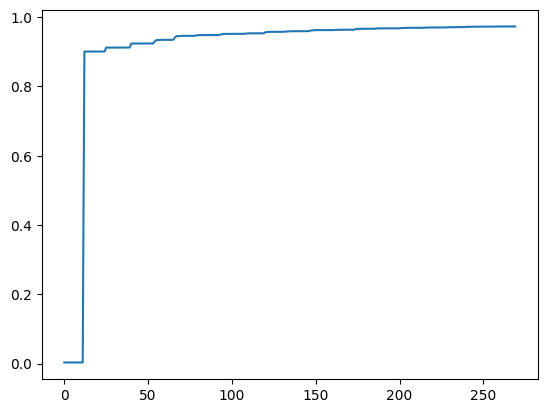

In [250]:
plt.plot(full_expectations[8][0])

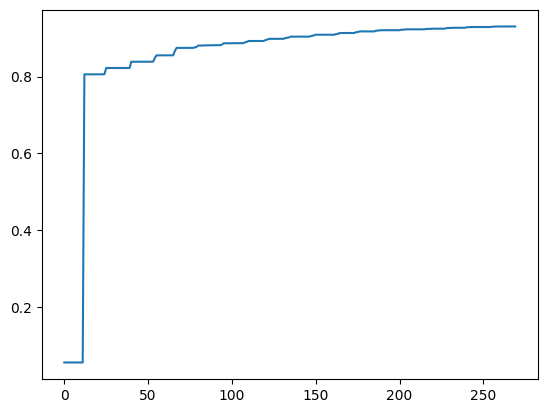

In [251]:
plt.plot(full_expectations[9][0])

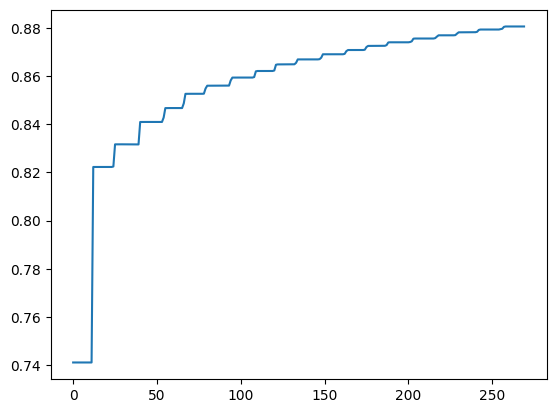

In [252]:
plt.plot(full_expectations[11][0])

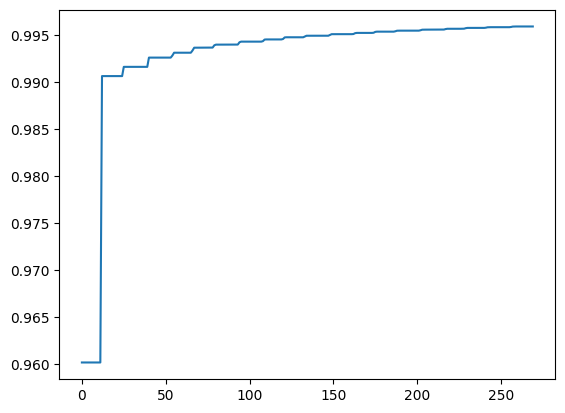

In [253]:
plt.plot(full_expectations[20][0])

# Calculate SPT phase

## Function definitions

In [332]:
def get_num_legs(unitary):
    ll = unitary.get_leg_labels()[0]

    return len(ll[1:-1].split('.'))

In [333]:
def group_by_lengths(l, lengths):
    out = list()

    current_index = 0

    for n in lengths:
        current_group = l[current_index:current_index+n]
        out.append(current_group)

        current_index += n

    return out

In [334]:
def multiply_unitaries_against_mps(unitaries, b_tensors, left_schmidt_values,
                                  max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    site_group_lens = [get_num_legs(u) for u in unitaries]

    grouped_bs = group_by_lengths(b_tensors, site_group_lens)
    grouped_schmidt_values = group_by_lengths(
        left_schmidt_values,
        site_group_lens
    )

    combined_bs = combine_grouped_b_tensors(grouped_bs)

    for i, u in enumerate(unitaries):
        b = combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    return new_top_bs, new_left_schmidt_values

In [335]:
def multiply_stacked_unitaries_against_mps(unitaries, b_tensors,
    left_schmidt_values, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    out_b_tensors = b_tensors.copy()
    out_left_schmidt_values = left_schmidt_values.copy()

    for l in unitaries:
        out_b_tensors, out_left_schmidt_values = multiply_unitaries_against_mps(
            l,
            out_b_tensors,
            out_left_schmidt_values,
            max_virtual_bond_dim
        )

    return out_b_tensors, out_left_schmidt_values

In [336]:
def mps_inner_product(
        top_tensors, bottom_tensors, left_environment):

    b_top = top_tensors[0]
    b_bottom = bottom_tensors[0]

    t = npc.tensordot(left_environment, b_bottom.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b_top, (['vR', 'p*'], ['vL', 'p']))

    for b_top, b_bottom in zip(top_tensors[1:], bottom_tensors[1:]):
        t = npc.tensordot(t, b_bottom.conj(), (['vR*',], ['vL*',]))
        t = npc.tensordot(t, b_top, (['vR', 'p*'], ['vL', 'p']))

    e = npc.trace(t, 'vR', 'vR*')

    return e

In [361]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = mps_inner_product(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

## Group data definitions

In [338]:
from itertools import combinations

In [339]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [340]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [341]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [342]:
e, a, b, c = symmetry_labels

In [343]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

## Get right phases

In [362]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

In [365]:
right_proj_rep_phases = list()

iterable = zip(
    right_mps_tensors,
    right_side_left_schmidt_values,
    right_unitaries,
    cases
)
for mps, schmidt, unitaries, case_list in iterable:
    phases = get_proj_rep_phases(
        mps,
        schmidt,
        unitaries,
        case_list[0].right_projected_symmetry_state
    )

    right_proj_rep_phases.append(phases)

right_proj_rep_phases = np.array(right_proj_rep_phases)

In [366]:
right_gauge_invariant_phases = (
    right_proj_rep_phases[:,::2]/
    right_proj_rep_phases[:,1::2]
)

In [368]:
right_gauge_invariant_phases[:10]

array([[-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j]])

In [369]:
right_gauge_invariant_phases[11:]

array([[1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j]])

In [370]:
left_proj_rep_phases = list()

iterable = zip(
    left_mps_tensors,
    left_side_right_schmidt_values,
    left_unitaries,
    cases
)
for mps, schmidt, unitaries, case_list in iterable:
    phases = get_proj_rep_phases(
        mps,
        schmidt,
        unitaries,
        swap_left_right_indices(case_list[0].left_projected_symmetry_state)
    )

    left_proj_rep_phases.append(phases)

left_proj_rep_phases = np.array(left_proj_rep_phases)

In [371]:
left_gauge_invariant_phases = (
    left_proj_rep_phases[:,::2]/
    left_proj_rep_phases[:,1::2]
)

In [372]:
left_gauge_invariant_phases[:10]

array([[-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j]])

In [373]:
left_gauge_invariant_phases[11:]

array([[1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j]])

# Conclusion
Looks good!